In [1]:
import pandas as pd
import urllib.request as req
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re

In [ ]:
sk_data=[]
day=[]
cond1={"class":"tah p10 gray03"}
cond2={"class":"tah p11"}

for i in range(400):
    url="https://finance.naver.com/item/sise_day.nhn?code=000660&page="+str(i+1)
    res=req.urlopen(url)
    soup=BeautifulSoup(res,"html.parser")

    a1=soup.find_all("span",cond1)
    a2=soup.find_all("span",cond2)
    for t in a1:
        day.append(int(t.string.replace('.','')))
    for t in a2:
        if t.string!='0':
            sk_data.append(int(t.string.replace(',','')))

sk_data=np.hstack([np.array(day).reshape(-1,1),np.array(sk_data).reshape(-1,5)])

In [ ]:
sk_data_t=sk_data

In [ ]:
df=pd.DataFrame(sk_data_t,columns=['date','close','open','high','low','volumn'])
df.to_csv("sk_hynix.csv",header=True,index=False)

In [2]:
df=pd.read_csv("sk_hynix.csv")
df.drop("date",axis=1,inplace=True)
df.tail()

,close,open,high,low,volumn
3995,6160,6320,6560,5910,40876521
3996,6320,5900,6750,5730,64117923
3997,5950,5330,5950,5330,55326942
3998,5180,5800,5960,5180,43046920
3999,6090,5900,6420,5650,56158263


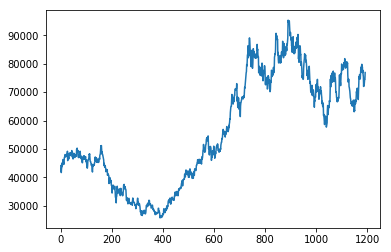

In [3]:
def MinMaxScaler(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/denominator

timesteps=7
input_dim=5
output_dim=1

xy=np.array(df)[::-1]
# xy=MinMaxScaler(xy)

dataX=[]
dataY=[]
for i in range(len(xy)-timesteps):
    dataX.append(xy[i:i+timesteps])
    dataY.append(xy[i+timesteps,[0]])

train_num=int(len(xy)*0.7)
train_x=np.array(dataX[:train_num])
train_y=np.array(dataY[:train_num])
test_x=np.array(dataX[train_num:])
test_y=np.array(dataY[train_num:])

plt.plot(test_y)